In [37]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

# Load and prepare data (same as before)
words = open('names.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

block_size = 4
def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [32]:
print(f"Training set: {Xtr.shape[0]} examples")
print(f"Dev set: {Xdev.shape[0]} examples")
print(f"Test set: {Xte.shape[0]} examples")

Training set: 182625 examples
Dev set: 22655 examples
Test set: 22866 examples


In [33]:
g = torch.Generator().manual_seed(2147483647)

# Better initialization and architecture
C = torch.randn((27, 16), generator=g) * 0.1  # Larger embeddings, better init
W1 = torch.randn((64, 300), generator=g) * (5/3) / (64**0.5)  # Xavier-like init
b1 = torch.randn(300, generator=g) * 0.01  # Small bias init
W2 = torch.randn((300, 27), generator=g) * 0.01  # Small final layer init
b2 = torch.randn(27, generator=g) * 0.01

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

# IMPROVED TRAINING LOOP
lossi = []
stepi = []
lri = []

# Learning rate schedule
max_steps = 200000
lr_decay_steps = max_steps


In [34]:
for i in range(max_steps):
    # Dynamic batch size - start smaller, increase over time
    if i < 1000:
        batch_size = 32
    elif i < 10000:
        batch_size = 64
    else:
        batch_size = 128
    
    # Sample batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    
    # Forward pass
    emb = C[Xtr[ix]]  # (batch_size, 4, 16)
    embcat = emb.view(-1, 64)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)  # (batch_size, 300)
    logits = h @ W2 + b2  # (batch_size, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Learning rate schedule: cosine annealing with warmup
    if i < 1000:  # Warmup
        lr = 0.1 * (i / 1000)
    else:  # Cosine annealing
        progress = (i - 1000) / (max_steps - 1000)
        lr = 0.01 + 0.09 * (1 + torch.cos(torch.tensor(progress * 3.14159))) / 2
    
    # Gradient clipping
    total_norm = 0
    for p in parameters:
        if p.grad is not None:
            total_norm += p.grad.data.norm(2).item() ** 2
    total_norm = total_norm ** 0.5
    
    clip_norm = 1.0
    if total_norm > clip_norm:
        for p in parameters:
            if p.grad is not None:
                p.grad.data.mul_(clip_norm / total_norm)
    
    # Update parameters
    for p in parameters:
        p.data += -lr * p.grad
    
    # Logging
    if i % 10000 == 0:
        print(f"Step {i}: loss = {loss.item():.4f}, lr = {lr:.6f}")
    
    stepi.append(i)
    lossi.append(loss.log10().item())
    lri.append(lr)

Step 0: loss = 3.2917, lr = 0.000000
Step 10000: loss = 2.1435, lr = 0.099547
Step 20000: loss = 2.0138, lr = 0.097991
Step 30000: loss = 2.0343, lr = 0.095366
Step 40000: loss = 1.9890, lr = 0.091737
Step 50000: loss = 1.9145, lr = 0.087194
Step 60000: loss = 2.0639, lr = 0.081851
Step 70000: loss = 1.9065, lr = 0.075840
Step 80000: loss = 1.8744, lr = 0.069311
Step 90000: loss = 1.8068, lr = 0.062425
Step 100000: loss = 1.9704, lr = 0.055355
Step 110000: loss = 1.8219, lr = 0.048276
Step 120000: loss = 1.8614, lr = 0.041365
Step 130000: loss = 1.7081, lr = 0.034792
Step 140000: loss = 1.8177, lr = 0.028722
Step 150000: loss = 1.8089, lr = 0.023306
Step 160000: loss = 1.9836, lr = 0.018678
Step 170000: loss = 1.8719, lr = 0.014953
Step 180000: loss = 1.8108, lr = 0.012224
Step 190000: loss = 1.8461, lr = 0.010560


(array([6577., 1640., 1112.,  935.,  697.,  706.,  572.,  526.,  539.,
         462.,  444.,  413.,  432.,  405.,  355.,  332.,  321.,  386.,
         319.,  397.,  344.,  384.,  246.,  290.,  358.,  298.,  300.,
         338.,  328.,  387.,  324.,  323.,  290.,  321.,  295.,  390.,
         351.,  366.,  430.,  453.,  512.,  488.,  526.,  549.,  670.,
         784.,  873., 1159., 1564., 6889.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

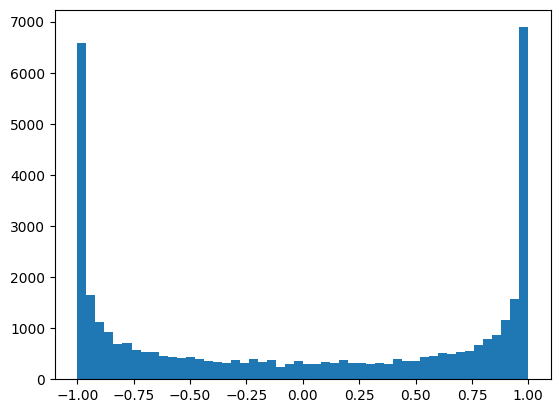

In [28]:
plt.hist(h.view(-1).tolist(), 50)

(array([1.000e+00, 5.000e+00, 4.000e+00, 9.000e+00, 5.000e+00, 1.800e+01,
        3.500e+01, 6.100e+01, 8.300e+01, 1.150e+02, 1.260e+02, 2.160e+02,
        3.100e+02, 4.270e+02, 5.150e+02, 7.300e+02, 9.700e+02, 1.298e+03,
        1.639e+03, 2.177e+03, 2.576e+03, 3.168e+03, 3.544e+03, 3.553e+03,
        3.259e+03, 2.964e+03, 2.431e+03, 1.938e+03, 1.552e+03, 1.215e+03,
        8.860e+02, 7.230e+02, 5.020e+02, 3.980e+02, 2.920e+02, 1.940e+02,
        1.560e+02, 9.700e+01, 8.000e+01, 4.300e+01, 2.200e+01, 2.200e+01,
        2.000e+01, 1.000e+01, 5.000e+00, 3.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00]),
 array([-10.49126244, -10.04158615,  -9.59190987,  -9.14223358,
         -8.6925573 ,  -8.24288101,  -7.79320473,  -7.34352844,
         -6.89385216,  -6.44417587,  -5.99449959,  -5.5448233 ,
         -5.09514702,  -4.64547073,  -4.19579445,  -3.74611816,
         -3.29644188,  -2.84676559,  -2.39708931,  -1.94741302,
         -1.49773674,  -1.04806046,  -0.59838417,  -0.14

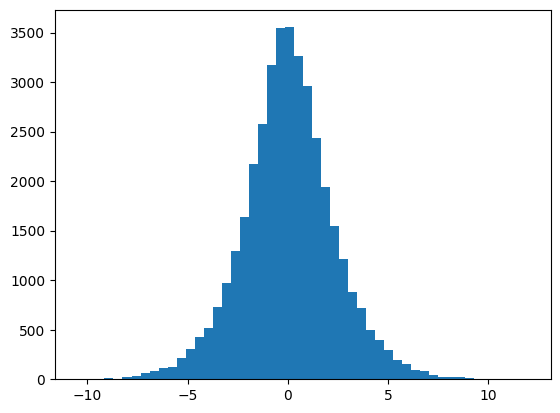

In [29]:
plt.hist(hpreact.view(-1).tolist(), 50)

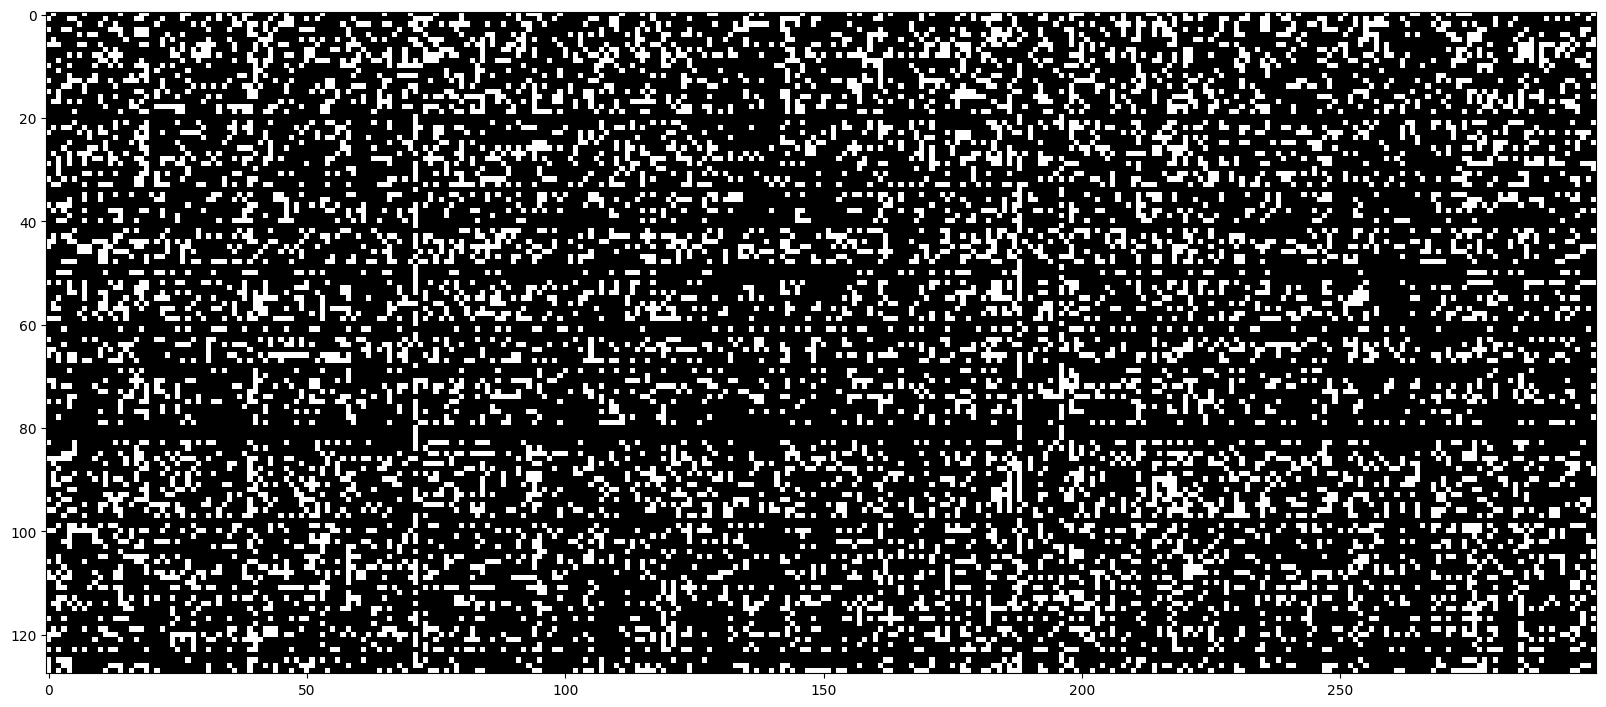

In [30]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

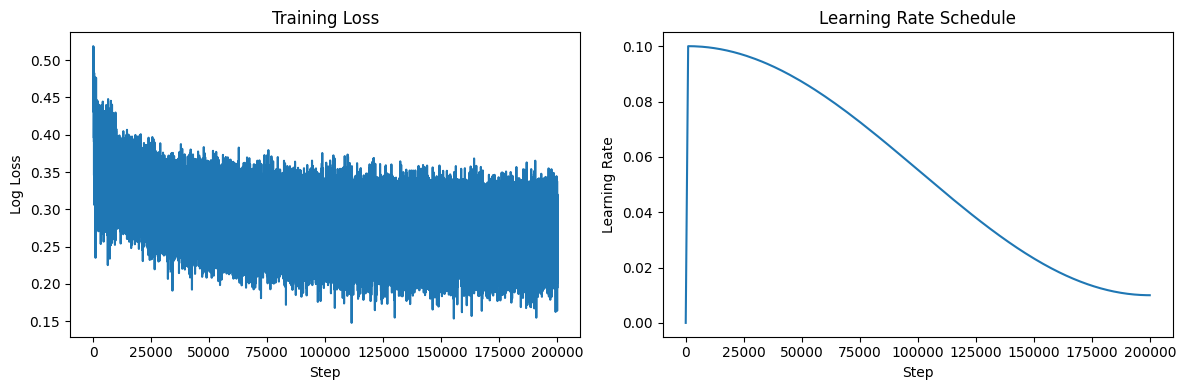


EVALUATION RESULTS
Training loss: 1.8523
Dev loss: 2.0412


In [35]:
# Plot training curve
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(stepi, lossi)
plt.xlabel('Step')
plt.ylabel('Log Loss')
plt.title('Training Loss')

plt.subplot(1, 2, 2)
plt.plot(stepi, lri)
plt.xlabel('Step')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')

plt.tight_layout()
plt.show()

# EVALUATION
print("\n" + "="*50)
print("EVALUATION RESULTS")
print("="*50)

# Training loss
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 64) @ W1 + b1)
logits = h @ W2 + b2
train_loss = F.cross_entropy(logits, Ytr)
print(f"Training loss: {train_loss.item():.4f}")

# Dev loss
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 64) @ W1 + b1)
logits = h @ W2 + b2
dev_loss = F.cross_entropy(logits, Ydev)
print(f"Dev loss: {dev_loss.item():.4f}")


In [36]:
# SAMPLE GENERATION
print("\n" + "="*50)
print("SAMPLE GENERATIONS")
print("="*50)

g = torch.Generator().manual_seed(2147483647)
for _ in range(10):
    context = [0] * 4
    name = ""
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        if ix == 0:
            break
        name += itos[ix]
    print(name)


SAMPLE GENERATIONS
celia
mouhner
rochi
ahneem
imitra
nyland
zakia
kremiyah
jaxson
mari
